# Oracle generation for 3-SAT problems

This notebook demonstrates Classiq's capabilities in the framework of phase oracles. The focus is 3-SAT problems on a growing number of variables. To highlight the advantage of generation times, we skip transpilation for the synthesis output.

The following utility functions generate random 3-SAT problems for $N$ boolean variables, consisting of $N$ clauses.

In [2]:
import numpy as np

from classiq.qmod.symbolic import logical_and, logical_not, logical_or


def generate_permutation_for_3sat_expression(num_qubits, max_samples=1000):
    """
    A function that generates two permutations on a list of num_qubits variables,
    for introducing a random and valid 3-SAT problem
    """

    direct_arr = np.array([k for k in range(num_qubits)])
    for k in range(max_samples):
        permut1 = np.random.permutation(num_qubits)
        permut2 = np.random.permutation(num_qubits)
        if (
            (0 not in permut2 - direct_arr)
            and (0 not in permut1 - direct_arr)
            and (0 not in permut1 - permut2)
        ):
            break

    assert (
        k < max_samples
    ), "Could not find a random 3-SAT problem, try to increase max_samples"
    return direct_arr, permut1, permut2


def generate_3sat_qbit_expression(vars, s0, s1, s2):
    """
    A function that generates a 3-SAT problem on a list of QBit variables.
    The returned expression contains num_qubits=len(vars) clauses and contains
    triplets of the form (x_k or ~x_s1(k) or x_s2(k)), where s1, s2 are permutations.
    """

    num_qubits = len(vars)
    k = 0
    y = logical_or(logical_or(vars[s0[k]], logical_not(vars[s1[k]])), vars[s2[k]])
    for k in range(1, num_qubits):
        temp = logical_or(
            logical_or(vars[s0[k]], logical_not(vars[s1[k]])), vars[s2[k]]
        )
        y = logical_and(y, temp)
    return y

## 1. Generating Phase Oracles

For each 3-SAT problem we generate an oracle with Classiq and save the generation time, as well as the circuits' width. 

In [3]:
from classiq import (
    Constraints,
    H,
    OptimizationParameter,
    Output,
    Preferences,
    QNum,
    QuantumProgram,
    X,
    allocate,
    create_model,
    qfunc,
    set_constraints,
    set_preferences,
    synthesize,
    within_apply,
)


def get_generation_time_classiq(s0, s1, s2, num_qubits):

    start_cl = time.time()

    @qfunc
    def main():

        def inner_call(aux: QNum):
            aux ^= generate_3sat_qbit_expression(
                [dict_of_qnums[f"x{k}"] for k in range(num_qubits)], s0, s1, s2
            )

        dict_of_qnums = {f"x{k}": QNum(f"x{k}") for k in range(num_qubits)}
        for k in range(num_qubits):
            allocate(1, dict_of_qnums[f"x{k}"])
        aux = QNum("aux")
        allocate(1, aux)
        within_apply(
            lambda: (X(aux), H(aux)),
            lambda: inner_call(aux),
        )

    qmod = create_model(main)
    qmod = set_preferences(qmod, preferences=Preferences(transpilation_option="none"))
    qprog = synthesize(qmod)
    cir = QuantumProgram.from_qprog(qprog)

    return cir.data.width, time.time() - start_cl

The following function generates a phase oracle with qiskit.

In [4]:
def get_generation_time_qiskit(s0, s1, s2, num_qubits):

    start_qs = time.time()
    dict_of_qnums = {f"x{k}": QNum(f"x{k}") for k in range(num_qubits)}
    expression = str(
        generate_3sat_qbit_expression(
            [dict_of_qnums[f"x{k}"] for k in range(num_qubits)], s0, s1, s2
        )
    )
    expression = expression.replace("or", "|")
    expression = expression.replace("not", "~")
    expression = expression.replace("and", "&")
    oracle = PhaseOracle(expression, var_order=None)
    q = QuantumRegister(num_qubits)
    qc = QuantumCircuit(q)
    qc.append(oracle, q[:])

    return time.time() - start_qs

*For generating the same data with Qiskit please uncomment the commented lines (including the `pip install command`).* We work with qiskit version 1.0.0.

In [5]:
import time

from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PhaseOracle

from classiq import CustomHardwareSettings, Preferences, RegisterUserInput, synthesize

We skip generating data with Qiskit for $N>23$, as generation times exponentially diverge with the number of variables.  

In [6]:
np.random.seed(128)
cl_times = []
num_qubits_list = [k for k in range(10, 23)] + [
    int(l) for l in np.logspace(np.log2(24), np.log2(68), 10, base=2)
]

In [7]:
# from importlib.metadata import version
# try:
#     import qiskit
#     if version('qiskit') != "1.0.0":
#       !pip uninstall qiskit -y
#       !pip install qiskit==1.0.0
# except ImportError:
#     !pip install qiskit==1.0.0

# ! pip install tweedledum
# qs_times = []

In [8]:
for l in num_qubits_list:
    num_qubits = l
    print("num_qubits:", num_qubits)
    s0, s1, s2 = generate_permutation_for_3sat_expression(num_qubits)

    cl_width, classiq_generation_time = get_generation_time_classiq(
        s0, s1, s2, num_qubits
    )
    cl_times.append(classiq_generation_time)
    print("classiq_width:", cl_width, ",   classiq_time:", classiq_generation_time)

    # if l<23:
    #     qiskit_generation_time = get_generation_time_qiskit(s0, s1, s2, num_qubits)
    #     qs_times.append(qiskit_generation_time)
    #     print("qiskit_time:", qiskit_generation_time)

num_qubits: 10
classiq_width: 21 ,   classiq_time: 2.2342519760131836
num_qubits: 11
classiq_width: 24 ,   classiq_time: 2.1264989376068115
num_qubits: 12
classiq_width: 26 ,   classiq_time: 2.1227452754974365
num_qubits: 13
classiq_width: 28 ,   classiq_time: 2.1253809928894043
num_qubits: 14
classiq_width: 30 ,   classiq_time: 2.1289098262786865
num_qubits: 15
classiq_width: 32 ,   classiq_time: 2.14056396484375
num_qubits: 16
classiq_width: 34 ,   classiq_time: 2.1414260864257812
num_qubits: 17
classiq_width: 36 ,   classiq_time: 2.218695878982544
num_qubits: 18
classiq_width: 38 ,   classiq_time: 2.173229694366455
num_qubits: 19
classiq_width: 40 ,   classiq_time: 2.148393154144287
num_qubits: 20
classiq_width: 42 ,   classiq_time: 2.153247833251953
num_qubits: 21
classiq_width: 44 ,   classiq_time: 2.158281087875366
num_qubits: 22
classiq_width: 46 ,   classiq_time: 2.3974831104278564
num_qubits: 24
classiq_width: 50 ,   classiq_time: 3.242741107940674
num_qubits: 26
classiq_width

## 2. Plotting the Data

Since generating the data takes time we hard-coded the Qiskit results in the notebook. If you run this notebook by yourself please comment out the following cell.

In [9]:
qs_times = [
    0.23147010803222656,
    0.2850170135498047,
    2.6256730556488037,
    0.75693678855896,
    5.783859968185425,
    3.3723957538604736,
    3.9280269145965576,
    39.92809295654297,
    60.67643904685974,
    16.551968097686768,
    31.536834955215454,
    31.086618900299072,
    794.9081449508667,
]

(array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 [Text(0.1, 0, '$\\mathdefault{10^{-1}}$'),
  Text(1.0, 0, '$\\mathdefault{10^{0}}$'),
  Text(10.0, 0, '$\\mathdefault{10^{1}}$'),
  Text(100.0, 0, '$\\mathdefault{10^{2}}$'),
  Text(1000.0, 0, '$\\mathdefault{10^{3}}$')])

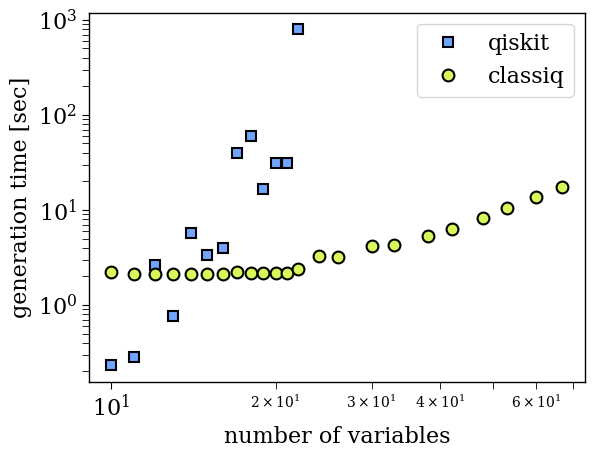

In [10]:
import matplotlib.pyplot as plt

classiq_color = "#D7F75B"
qiskit_color = "#6FA4FF"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)

plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5


plt.loglog(
    [n for n in num_qubits_list if n < 23],
    qs_times,
    "s",
    label="qiskit",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=qiskit_color,
)
plt.loglog(
    num_qubits_list,
    cl_times,
    "o",
    label="classiq",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=8.5,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color,
)

plt.legend(fontsize=16, loc="upper right")


plt.ylabel("generation time [sec]", fontsize=16)
plt.xlabel("number of variables", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)